## Segmentacao CNN [`resnet18`]
   1. Usar lib segmentation_models(https://github.com/qubvel/segmentation_models)
   2. Usar mobilenet, mobilenetv2 ou seresnet18 como backbone
   3. Usar FPN como arquitetura base
   4. Visualizar resultados

## Instalação de módulos 
[Caso não estejam presentes no ambiente]

In [1]:
# !pip install albumentations
# !pip install segmentation-models

## Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["SM_FRAMEWORK"] ="tf.keras"

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import segmentation_models as sm


Segmentation Models: using `tf.keras` framework.


## Definição de funções e classes auxiliares

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# helper function for data visualization
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['car','wheel','light','windows']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,dsize=(128,128),interpolation=cv2.INTER_AREA)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask,dsize=(128,128),interpolation=cv2.INTER_AREA)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)


class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches

    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """

    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return batch

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

### Definindo local da fonte de dados

In [4]:
base_path = './../../../../Datasets/Exercicio_Segmentacao/'

x_train_dir = f"{base_path}/train/images/"
y_train_dir = f"{base_path}/train/masks/"

x_valid_dir = f"{base_path}/valid/images/"
y_valid_dir = f"{base_path}/valid/masks/"

x_test_dir = f"{base_path}/test/images/"
y_test_dir = f"{base_path}/test/masks/"

### Definição de funções _ad hoc_

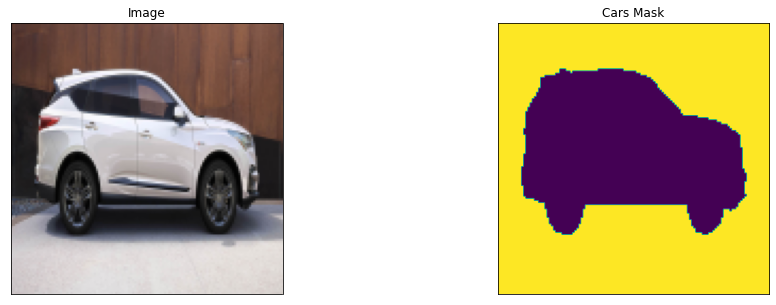

In [5]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = dataset[5] # get some sample
visualize(
    image=image,
    cars_mask=mask[..., 0].squeeze(),
    # sky_mask=mask[..., 1].squeeze(),
    # background_mask=mask[..., 2].squeeze(),
)

## Definição de parâmetros do modelo

In [6]:
BACKBONE = 'resnet18'
BATCH_SIZE = 4
CLASSES = ['car']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [7]:
# define network parameters

# case for binary and multiclass segmentation
n_classes = 1 if len(CLASSES) == 1 \
    else (len(CLASSES) + 1)  

# activation
activation = 'sigmoid' if n_classes == 1 \
    else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

44920640/44920640 [==============================] - 2s 0us/step


## Definição de métricas e otimizador

In [8]:
# define optomizer
optim = keras.optimizers.Adam(LR)

total_loss = sm.losses.binary_focal_dice_loss \
    if n_classes == 1 else sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

## Instanciação do _dataset_

In [9]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    classes=CLASSES,
    # augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    classes=CLASSES,
    # augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

## Treinamento do modelo

In [10]:
%%time
# train model
history = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
33/33 [==============================] - 46s 1s/step - loss: 0.3821 - iou_score: 0.7055 - f1-score: 0.8205 - val_loss: 1.1977 - val_iou_score: 0.0358 - val_f1-score: 0.0679 - lr: 1.0000e-04
Epoch 2/10
33/33 [==============================] - 31s 954ms/step - loss: 0.2247 - iou_score: 0.8721 - f1-score: 0.9310 - val_loss: 0.4916 - val_iou_score: 0.5172 - val_f1-score: 0.6749 - lr: 1.0000e-04
Epoch 3/10
33/33 [==============================] - 33s 1s/step - loss: 0.1585 - iou_score: 0.9115 - f1-score: 0.9534 - val_loss: 0.2844 - val_iou_score: 0.7782 - val_f1-score: 0.8714 - lr: 1.0000e-04
Epoch 4/10
33/33 [==============================] - 33s 995ms/step - loss: 0.1228 - iou_score: 0.9355 - f1-score: 0.9665 - val_loss: 0.2018 - val_iou_score: 0.8631 - val_f1-score: 0.9245 - lr: 1.0000e-04
Epoch 5/10
33/33 [==============================] - 33s 1s/step - loss: 0.0996 - iou_score: 0.9526 - f1-score: 0.9756 - val_loss: 0.1573 - val_iou_score: 0.9001 - val_f1-score: 0.9458 - lr: 

## Visualização dos resultados

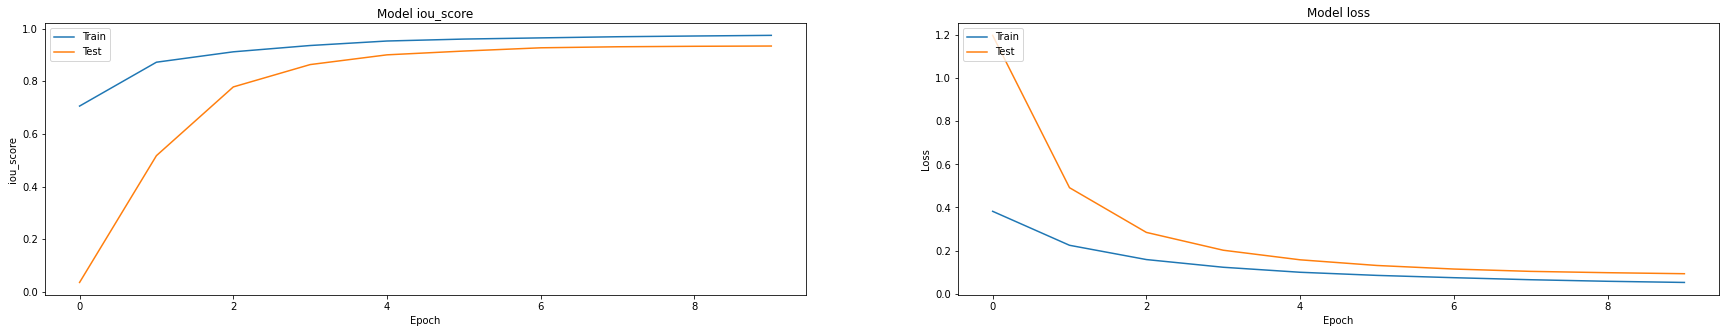

In [11]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## Início dos testes

In [12]:
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    classes=CLASSES,
    # augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [13]:
# load best weights
model.load_weights('best_model.h5')

In [14]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

43/43 [==============================] - 4s 96ms/step - loss: 0.0886 - iou_score: 0.9383 - f1-score: 0.9672
Loss: 0.088599
mean iou_score: 0.93833
mean f1-score: 0.9672


## Visualização dos testes

1/1 [==============================] - 1s 586ms/step


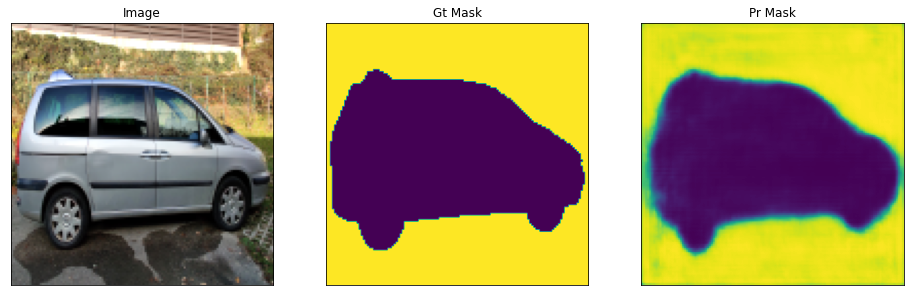

1/1 [==============================] - 0s 53ms/step


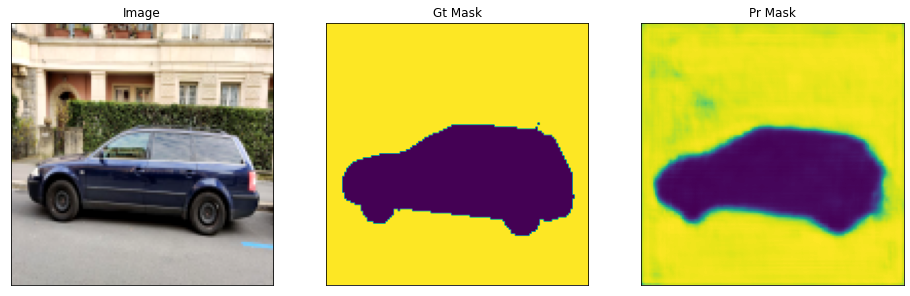

1/1 [==============================] - 0s 50ms/step


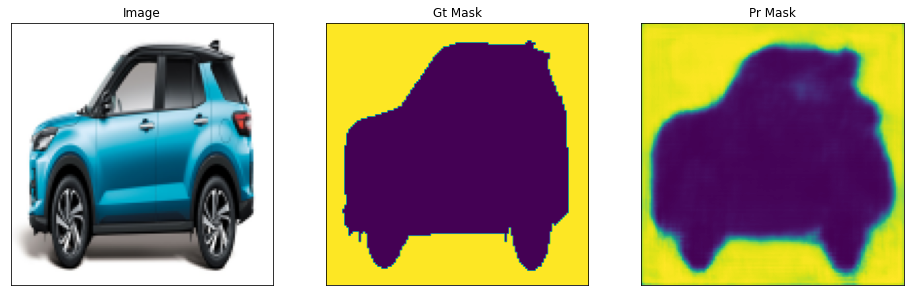

1/1 [==============================] - 0s 58ms/step


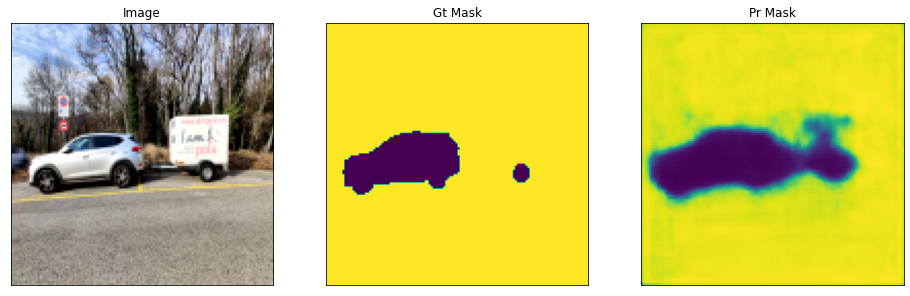

1/1 [==============================] - 0s 58ms/step


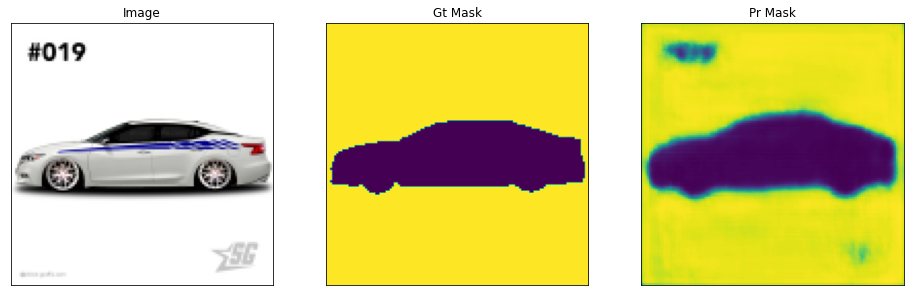

In [15]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:

    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)

    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )